In [1]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from shapely.geometry import Point, box
import os

In [2]:
# data_nyc\zones.geojson

zone = gpd.read_file('../data_nyc/zones.geojson')
zone = zone.reset_index(drop=True)
zone.head()

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."


In [3]:
minx, miny, maxx, maxy = zone.total_bounds
bbox = box(minx, miny, maxx, maxy)

In [4]:
temp = zone.copy()
temp.head()

# save temp
# temp.to_file('../data_nyc/temp.geojson', driver='GeoJSON')

,ZONEDIST,date,time,geometry
0,['R3A' 'PARK'],2024-01-01,0:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
1,['R3A' 'PARK'],2024-01-01,1:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
2,['R3A' 'PARK'],2024-01-01,2:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
3,['R3A' 'PARK'],2024-01-01,3:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."
4,['R3A' 'PARK'],2024-01-01,4:00,"POLYGON ((913013.301 118296.425, 916294.141 11..."


In [5]:
# pm2_5
# data\pm2_5.csv

pm2_5 = pd.read_csv('../data/pm2_5FRM.csv', low_memory=False)

In [6]:
pm2_5.columns

Index(['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Date Local',
       'Time Local', 'Date GMT', 'Time GMT', 'Sample Measurement',
       'Units of Measure', 'MDL', 'Uncertainty', 'Qualifier', 'Method Type',
       'Method Code', 'Method Name', 'State Name', 'County Name',
       'Date of Last Change'],
      dtype='object')

In [7]:
# 'State Code', 'County Code', 'Site Num', 'Parameter Code', 'Latitude', 'Longitude', 'Datum', 'Date Local',
# 'Time Local', 'Sample Measurement', 'Units of Measure', 'Uncertainty', 'State Name', 'County Name'

params = ['State Code', 'County Code', 'Site Num', 'Parameter Code', 'Latitude', 'Longitude', 'Datum', 'Date Local','Time Local', 'Sample Measurement', 'Units of Measure', 'Uncertainty', 'State Name', 'County Name']
pm2_5 = pm2_5[params]

In [8]:
pm2_5_gdf = gpd.GeoDataFrame(
    pm2_5,
    geometry=[Point(xy) for xy in zip(pm2_5['Longitude'], pm2_5['Latitude'])],
    crs='EPSG:4326'
)
pm2_5_gdf = pm2_5_gdf.to_crs('EPSG:2263')
pm2_5_gdf = pm2_5_gdf[pm2_5_gdf.geometry.within(bbox)]

In [9]:
pm2_5_gdf.rename(columns={'Date Local': 'date', 'Time Local': 'time', 'Sample Measurement': 'pm2_5 measurement', 'Units of Measure': 'pm2_5 unit'}, inplace=True)
pm2_5_temp = pm2_5_gdf.copy()
pm2_5_temp = pm2_5_temp[['date', 'time', 'pm2_5 measurement', 'pm2_5 unit', 'geometry']]
pm2_5_temp.head()

,date,time,pm2_5 measurement,pm2_5 unit,geometry
2643999,2024-01-01,00:00,19.5,Micrograms/cubic meter (LC),POINT (993605.973 250250.739)
2644000,2024-01-01,01:00,20.7,Micrograms/cubic meter (LC),POINT (993605.973 250250.739)
2644001,2024-01-01,02:00,17.7,Micrograms/cubic meter (LC),POINT (993605.973 250250.739)
2644002,2024-01-01,03:00,19.0,Micrograms/cubic meter (LC),POINT (993605.973 250250.739)
2644003,2024-01-01,04:00,21.0,Micrograms/cubic meter (LC),POINT (993605.973 250250.739)


In [10]:
temp['date'] = pd.to_datetime(temp['date']).dt.date
pm2_5_temp['date'] = pd.to_datetime(pm2_5_temp['date']).dt.date

temp   ['time'] = pd.to_datetime(temp['time'], format='%H:%M').dt.strftime('%H:%M')
pm2_5_temp['time'] = pd.to_datetime(pm2_5_temp['time'], format='%H:%M').dt.strftime('%H:%M')


all_results = []

# loop over dates, '2024-01-01', ..., '2024-06-30'
for current_date in pd.date_range('2024-01-01','2024-06-30',freq='D'):
    d = current_date.date()             
    temp_d = temp[temp['date']==d]
    if temp_d.empty: 
        continue
    
    # loop over hours, '00', '01', ..., '23'
    for hour in range(24):
        time_label = f"{hour:02d}:00" 
        temp_h = temp_d[temp_d['time']==time_label]
        pm2_5_h   = pm2_5_temp[
            (pm2_5_temp['date']==d) & 
            (pm2_5_temp['time']==time_label)
        ]
        if temp_h.empty or pm2_5_h.empty:
            continue

        joined = gpd.sjoin(
            temp_h,
            pm2_5_h[['geometry','pm2_5 measurement']],
            how='left',
            predicate='contains'
        ).drop(columns=['index_right'])

        agg = (
            joined
            .groupby(['date','time','geometry'])['pm2_5 measurement']
            .mean()
            .reset_index()
            
        )
        agg = gpd.GeoDataFrame(agg, geometry='geometry', crs=temp_h.crs)

        res_h = temp_h.merge(
            agg[['date','time','geometry','pm2_5 measurement']],
            on=['date','time','geometry'],
            how='left'
        )
        all_results.append(res_h)


In [11]:
result = gpd.GeoDataFrame(
    pd.concat(all_results, ignore_index=True),
    geometry='geometry',
    crs=temp.crs
)
result

,ZONEDIST,date,time,geometry,pm2_5 measurement
0,['R3A' 'PARK'],2024-01-01,00:00,"POLYGON ((913013.301 118296.425, 916294.141 11...",NaN
1,['R3A' 'R3-2' 'R3X' 'R1-2' 'PARK'],2024-01-01,00:00,"POLYGON ((916294.141 118296.425, 919574.981 11...",NaN
2,['R1-2' 'R3X' 'R1-1'],2024-01-01,00:00,"POLYGON ((919574.981 118296.425, 922855.821 11...",NaN
3,[ NaN ],2024-01-01,00:00,"POLYGON ((922855.821 118296.425, 926136.661 11...",NaN
4,[ NaN ],2024-01-01,00:00,"POLYGON ((926136.661 118296.425, 929417.501 11...",NaN
...,...,...,...,...,...
9648907,[ NaN ],2024-06-30,23:00,"POLYGON ((1050808.581 269215.065, 1054089.421 ...",NaN
9648908,[ NaN ],2024-06-30,23:00,"POLYGON ((1054089.421 269215.065, 1057370.261 ...",NaN
9648909,[ NaN ],2024-06-30,23:00,"POLYGON ((1057370.261 269215.065, 1060651.101 ...",NaN
9648910,[ NaN ],2024-06-30,23:00,"POLYGON ((1060651.101 269215.065, 1063931.941 ...",NaN


In [12]:
print(result.columns.tolist())

['ZONEDIST', 'date', 'time', 'geometry', 'pm2_5 measurement']


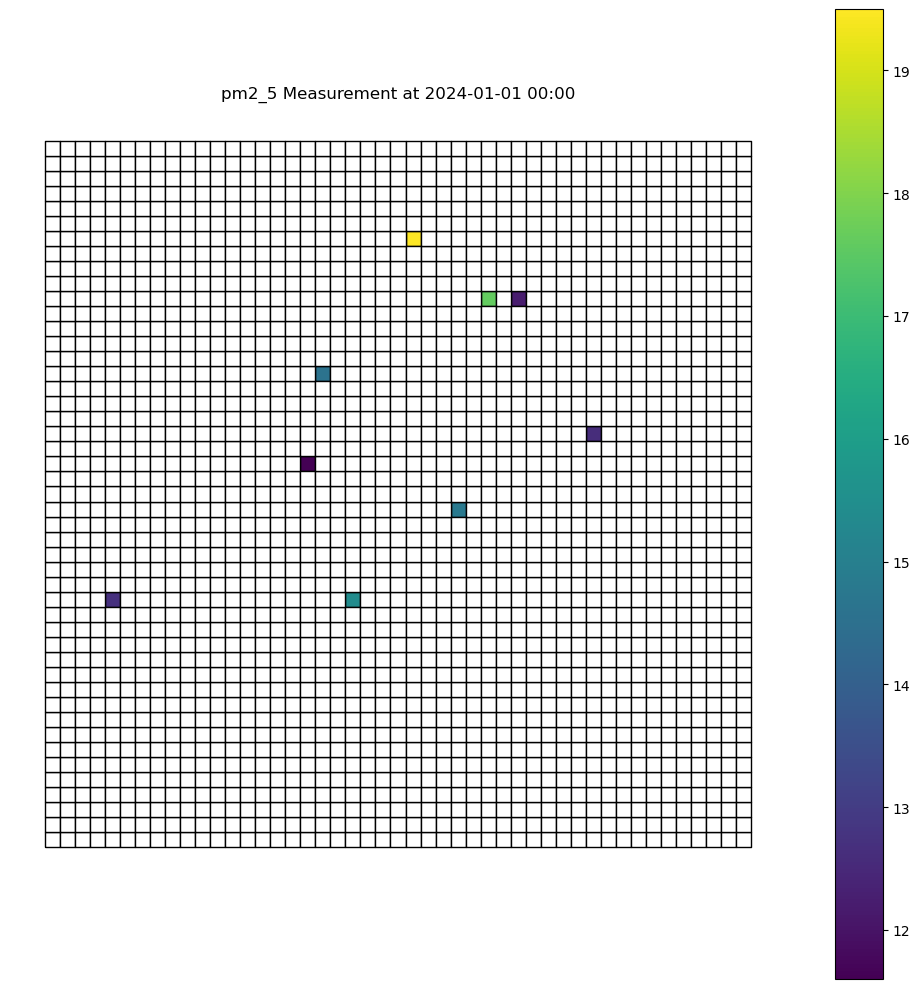

In [13]:
mask = (
    (result['date'] == pd.to_datetime('2024-01-01').date()) &
    (result['time'] == '00:00')
)
slice_0000 = result[mask]

fig, ax = plt.subplots(figsize=(10, 10))
slice_0000.plot(
    column='pm2_5 measurement',
    legend=True,
    edgecolor='black',
    missing_kwds={'color': 'white'},
    ax=ax
)
ax.set_title('pm2_5 Measurement at 2024-01-01 00:00')
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [14]:
# save result
result['time'] = result['time'].apply(lambda x: x.strftime('%H:%M') if not isinstance(x, str) else x)
result.to_file('../data_nyc/pm2_5.geojson', driver='GeoJSON')

In [15]:
result.to_csv('../data_nyc/pm2_5.csv', index=False)